## Get the data

In [2]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from numpy.linalg import inv
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns

cmap = sns.color_palette()

In [3]:
factor = pdr.get_data_famafrench('F-F_Research_Data_Factors', start='1-1-1926')
asset = pdr.get_data_famafrench('17_Industry_Portfolios', start='1-1-1926')

In [4]:
asset['DESCR'] # we want to test for 0 : Average Value Weighted Returns -- Monthly (1144 rows x 17 cols)

'17 Industry Portfolios\n----------------------\n\nThis file was created by CMPT_IND_RETS using the 202110 CRSP database. It contains value- and equal-weighted returns for 17 industry portfolios. The portfolios are constructed at the end of June. The annual returns are from January to December. Missing data are indicated by -99.99 or -999. Copyright 2021 Kenneth R. French\n\n  0 : Average Value Weighted Returns -- Monthly (1144 rows x 17 cols)\n  1 : Average Equal Weighted Returns -- Monthly (1144 rows x 17 cols)\n  2 : Average Value Weighted Returns -- Annual (94 rows x 17 cols)\n  3 : Average Equal Weighted Returns -- Annual (94 rows x 17 cols)\n  4 : Number of Firms in Portfolios (1144 rows x 17 cols)\n  5 : Average Firm Size (1144 rows x 17 cols)\n  6 : Sum of BE / Sum of ME (96 rows x 17 cols)\n  7 : Value-Weighted Average of BE/ME (96 rows x 17 cols)'

In [5]:
factor # 各月份的 risk-free rate (RF column)

{0:          Mkt-RF   SMB   HML    RF
 Date                             
 1926-07    2.96 -2.38 -2.73  0.22
 1926-08    2.64 -1.47  4.14  0.25
 1926-09    0.36 -1.39  0.12  0.23
 1926-10   -3.24 -0.13  0.65  0.32
 1926-11    2.53 -0.16 -0.38  0.31
 ...         ...   ...   ...   ...
 2021-06    2.75  1.80 -7.76  0.00
 2021-07    1.27 -3.96 -1.75  0.00
 2021-08    2.90 -0.48 -0.13  0.00
 2021-09   -4.37  0.80  5.09  0.00
 2021-10    6.65 -2.28 -0.45  0.00
 
 [1144 rows x 4 columns],
 1:       Mkt-RF    SMB    HML    RF
 Date                            
 1927   29.47  -2.83  -3.40  3.12
 1928   35.39   4.51  -6.17  3.56
 1929  -19.54 -30.69  11.65  4.75
 1930  -31.23  -5.34 -11.76  2.41
 1931  -45.11   3.64 -14.56  1.07
 ...      ...    ...    ...   ...
 2016   13.30   6.63  22.64  0.20
 2017   21.51  -4.95 -13.48  0.80
 2018   -6.93  -3.34  -9.80  1.81
 2019   28.28  -6.06 -10.48  2.14
 2020   23.67  12.77 -46.31  0.44
 
 [94 rows x 4 columns],
 'DESCR': 'F-F Research Data Factors\n-----

In [6]:
asset[0].tail(3) # 各產業各月份的 return

,Food,Mines,Oil,Clths,Durbl,Chems,Cnsum,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
Date,,,,,,,,,,,,,,,,,
2021-08,-0.29,-2.38,-1.53,-0.62,-3.66,-0.18,2.24,1.73,3.66,5.24,3.54,2.01,-0.97,3.22,3.01,2.66,3.94
2021-09,-3.28,-8.23,10.96,-9.06,-7.03,-4.42,-5.85,-3.60,-10.57,-5.51,-5.73,4.07,-2.54,-4.77,-5.16,-1.59,-5.76
2021-10,3.64,8.73,10.22,11.59,4.41,7.28,3.65,11.50,10.00,3.93,7.53,30.91,6.59,5.14,3.53,6.87,5.52


In [7]:
df_FF = factor[0].loc['1980':'2021']
df_R = asset[0].loc['1980':'2021']
df_ER = df_R.subtract(df_FF.RF,axis=0).shift(1)

注意到:  
- 是否為 out-of-sample 的差別只在是否有 .shift(1)
- 在上一個 cell 的```df_FF```, ```df_R```, ```df_ER``` 分別是這樣定義的:  
```python
df_FF = factor[0].loc[1980:2021]
df_R = asset[0].loc[1980:2021]
df_ER = df_R.subtract(df_FF.RF,axis=0).shift(1)
```
- 原因: 有 shift 代表只會在當期看到前一期看到 excess return，即 out of sample; 沒有 shift，代表你在當期時可以看到當期結束後的 excess return

In [8]:
df_ER.head()

,Food,Mines,Oil,Clths,Durbl,Chems,Cnsum,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
Date,,,,,,,,,,,,,,,,,
1980-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-02,3.05,12.93,13.02,1.88,3.92,3.16,-3.10,7.95,16.70,6.46,6.93,9.88,15.29,0.80,-0.55,1.29,3.14
1980-03,-6.18,2.88,11.73,-1.61,-6.18,-2.56,-4.91,-2.97,-0.79,-1.91,-4.71,-7.35,-7.43,-4.25,-6.21,-5.91,-2.22
1980-04,-10.15,-19.95,-18.97,-10.19,-6.77,-13.13,-4.02,-16.00,-19.85,-17.85,-13.97,-10.70,-14.13,-7.88,-9.33,-10.07,-11.05
1980-05,5.88,-1.82,5.58,2.39,0.93,3.55,3.81,2.76,1.05,2.77,-1.16,-4.31,-1.86,10.70,3.37,5.57,5.23


## Calculate analytical solutions

In [9]:
S = df_R.cov()
R = df_R.mean(axis=0)
ER = df_ER.mean(axis=0)
N = len(ER)
ONE = np.ones(len(ER))

GMVP = (inv(S) @ ONE) / (ONE.T @ inv(S) @ ONE)
MSRP = (inv(S) @ ER) / (ONE.T @ inv(S) @ ER)

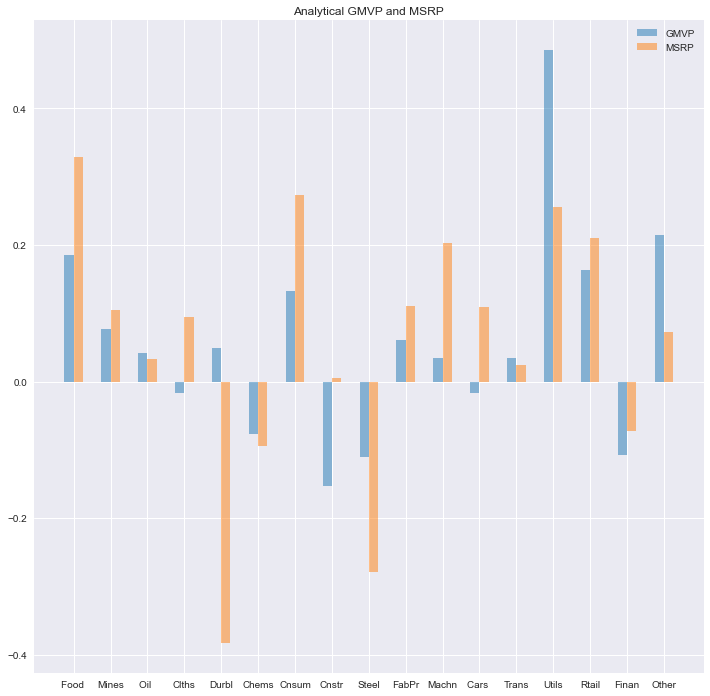

In [10]:
plt.style.use('seaborn')
ind = np.arange(N)

plt.figure(figsize=(12, 12))
plt.bar(ind, GMVP, width=0.25, alpha=0.5, color=cmap[0])
plt.bar(ind + 0.25, MSRP, width=0.25, alpha=0.5, color=cmap[1])
plt.xticks(ind + 0.25 / 2, ER.index)

plt.legend(['GMVP','MSRP'])
plt.title('Analytical GMVP and MSRP')
plt.show()


In [11]:
GMVP.sum() # 比例加起來等於 1 (沒有融資)

0.9999999999999993

In [12]:
MSRP.sum() # 比例加起來等於 1 (有融資)

1.000000000000001

可以看到用 analytical closed-form 的 MSRP 得出的結果不理想，因為在 durable goods 竟然要求放空 40%!  
而整個投資組合比例也超過 100% -> 代表要做 margin trading!  
=> 過度放空跟過度融資都是好的現象，而會這樣是因為我們直接帶公式!!  
=> 應該要對投組的 weight 做限制 -> numerical solutions

## find numerical solutions

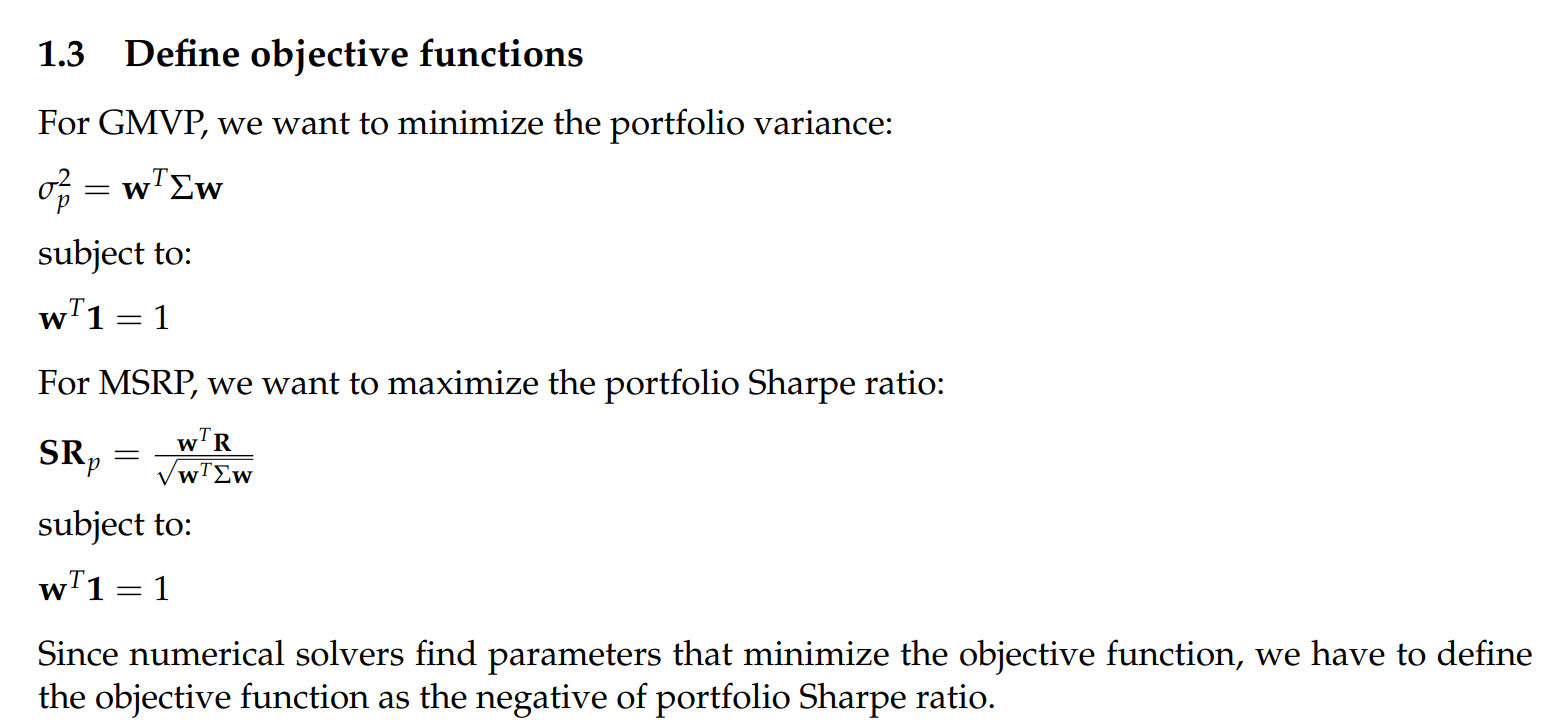


In [13]:
def pvar(w, S): # pvar = portfolio variance
    return (w.T @ S @ w)

def pret(w, ER): # pret = portfolio return
    return (w.T @ ER)

def sharpe(w, ER, S): # -(pret / 根號(pvar) )
    return -(w.T @ ER)/np.sqrt(w.T @ S @ w)

### step1: initial guess and get weights (for GMVP)

要先給 optimizer 一個起點，他才知道怎麼去找極值。  
因此假設 每支股票等權重 (i.e., Wi = 1/N)

In [14]:
x0 = np.ones(N)/N

# type: eq (equivalent)=> the weights must add up to 1
# x: weights
# minimize(你要 minimize 的 fcn, 最初猜想, method,arg=fcn 裡 given 的數, )
cons = ({'type': 'eq', 'fun' : lambda x: np.sum(x) - 1}),
NGMVP = minimize(pvar, x0, method='SLSQP', args=S, constraints=cons, options={'disp': True, 'ftol': 1e-9}
)
# SLSQP: Sequential Least SQuare Programming (for constraint optimization)
NGMVP

Optimization terminated successfully    (Exit mode 0)
            Current function value: 11.03892905865501
            Iterations: 21
            Function evaluations: 401
            Gradient evaluations: 21


     fun: 11.03892905865501
     jac: array([22.07785833, 22.07785821, 22.07785821, 22.07785809, 22.07785833,
       22.07785833, 22.07785857, 22.07785809, 22.07785821, 22.07785821,
       22.07785809, 22.07785833, 22.07785845, 22.07785833, 22.07785857,
       22.07785833, 22.07785809])
 message: 'Optimization terminated successfully'
    nfev: 401
     nit: 21
    njev: 21
  status: 0
 success: True
       x: array([ 0.18513174,  0.07713594,  0.0420442 , -0.01733065,  0.04893663,
       -0.07712731,  0.13288603, -0.15328899, -0.10987406,  0.0615344 ,
        0.03517646, -0.01662537,  0.03485098,  0.48540781,  0.16286507,
       -0.10706744,  0.21534455])

```
 x: array([ 0.18513174,  0.07713594,  0.0420442 , -0.01733065,  0.04893663,
       -0.07712731,  0.13288603, -0.15328899, -0.10987406,  0.0615344 ,
        0.03517646, -0.01662537,  0.03485098,  0.48540781,  0.16286507,
       -0.10706744,  0.21534455])
```
Optimizer 取得的 weights

### Step2: confirm that GMVP and NGMVP is the same

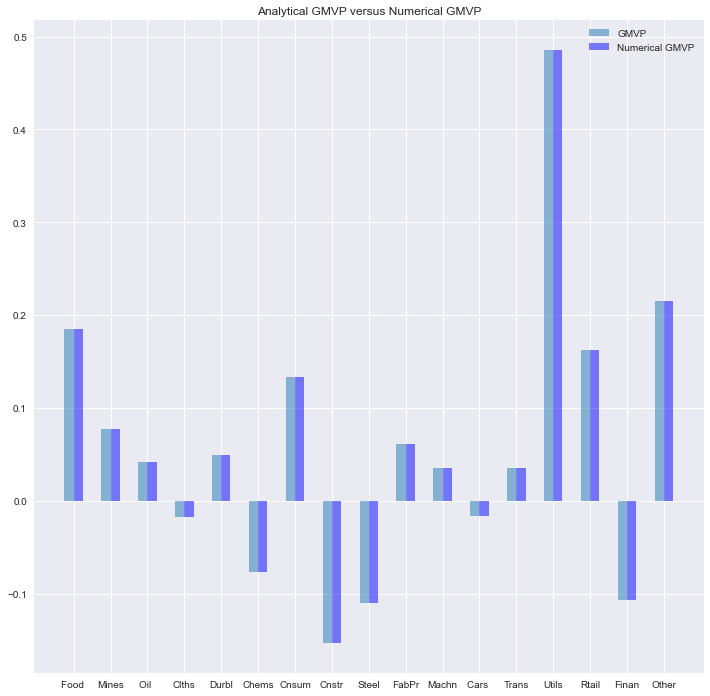

In [15]:
ind = np.arange(N)
plt.figure(figsize=(12, 12))

plt.bar(ind, GMVP, width=0.25, alpha=0.5, color=cmap[0])
plt.bar(ind + 0.25, NGMVP.x, width=0.25, alpha=0.5, color='blue')
plt.xticks(ind + 0.25 / 2, ER.index)


plt.legend(['GMVP','Numerical GMVP'])
plt.title('Analytical GMVP versus Numerical GMVP')
plt.show()

Numerial solution 跟 analytical 的相同!!!  
這是因為 numerical constraints 只有 weights 加起來 = 1，但 MSRP 也符合這項，所以得出一樣的結果

### step1: initial guess and get weights (for MSRP)

In [16]:
x0 = np.arange(N)/N
cons = ({'type': 'eq', 'fun' : lambda x: np.sum(x) - 1}),
NMSRP = minimize(sharpe, x0, method='SLSQP', args=(ER, S), constraints=cons, options={'disp': True, 'ftol': 1e-9})
NMSRP

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.25778589060143653
            Iterations: 32
            Function evaluations: 579
            Gradient evaluations: 32


     fun: -0.25778589060143653
     jac: array([-3.25590372e-06, -5.76674938e-06, -1.49384141e-06, -4.85032797e-06,
       -6.81728125e-06, -2.19792128e-06, -1.36792660e-05, -2.32830644e-06,
       -1.39065087e-05,  1.01327896e-06, -4.50387597e-06,  9.60007310e-06,
       -6.49690628e-06, -2.42143869e-07, -7.89761543e-06, -1.04643404e-05,
        1.54227018e-06])
 message: 'Optimization terminated successfully'
    nfev: 579
     nit: 32
    njev: 32
  status: 0
 success: True
       x: array([ 0.32936398,  0.10543008,  0.03363064,  0.0948844 , -0.38315863,
       -0.09464698,  0.27273584,  0.00577303, -0.27845641,  0.11113565,
        0.2035534 ,  0.10909262,  0.02384575,  0.25633434,  0.20987346,
       -0.0727575 ,  0.07336633])

### Step2: confirm that MSRP and NMSRP is the same

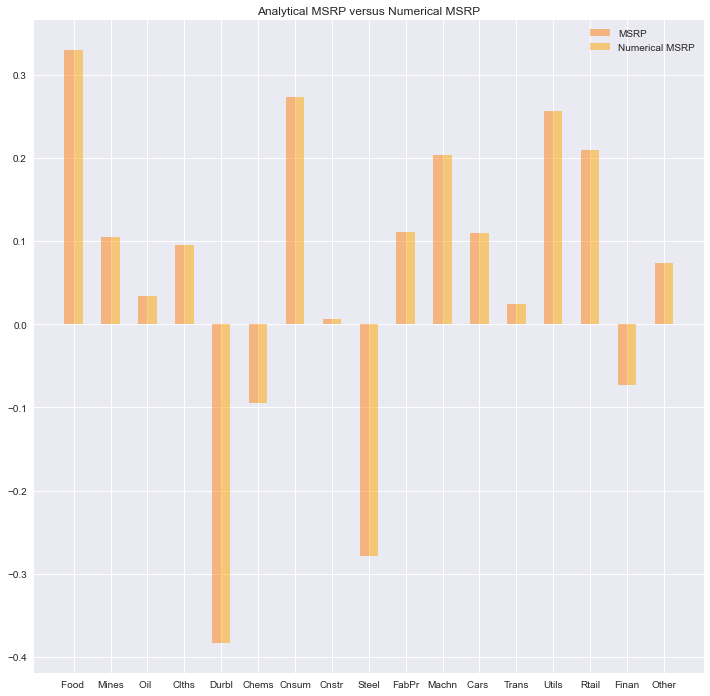

In [17]:
ind = np.arange(N)

plt.figure(figsize=(12, 12))
plt.bar(ind, MSRP, width=0.25, alpha=0.5, color=cmap[1])
plt.bar(ind + 0.25, NMSRP.x, width=0.25, alpha=0.5, color='orange')
plt.xticks(ind + 0.25 / 2, ER.index)

plt.legend(['MSRP','Numerical MSRP'])
plt.title('Analytical MSRP versus Numerical MSRP')
plt.show()

### Step1: Now add ADDITIONAL constraints

比上面的 code: 在 ```minimize()``` 裡多了 ```bounds``` parameter

In [18]:
from scipy.optimize import Bounds

bounds = Bounds(0, 1) # no margin trading and shortselling
x0 = GMVP
cons = ({'type': 'eq', 'fun' : lambda x: np.sum(x) - 1})

NGMVPnoSS = minimize(pvar, x0, method='SLSQP', constraints=cons, args=S,
options={'disp': True, 'ftol': 1e-9}, 
bounds=bounds
)

NGMVPnoSS

Optimization terminated successfully    (Exit mode 0)
            Current function value: 11.854969582863784
            Iterations: 11
            Function evaluations: 204
            Gradient evaluations: 11


     fun: 11.854969582863784
     jac: array([23.70994103, 23.70991898, 23.80013967, 25.87363076, 25.18939853,
       26.76456118, 23.70994151, 27.70517874, 28.99906838, 24.97839618,
       24.2929498 , 26.4506129 , 25.5953269 , 23.70994163, 23.70992935,
       27.07527363, 23.70993149])
 message: 'Optimization terminated successfully'
    nfev: 204
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([1.65891358e-01, 1.78253723e-02, 0.00000000e+00, 2.22941486e-15,
       5.44454356e-16, 1.70453543e-15, 1.64582010e-01, 7.00082916e-15,
       6.49580970e-15, 0.00000000e+00, 4.23479416e-16, 5.24881605e-15,
       0.00000000e+00, 5.00381601e-01, 8.17961938e-02, 5.01930549e-15,
       6.95234642e-02])

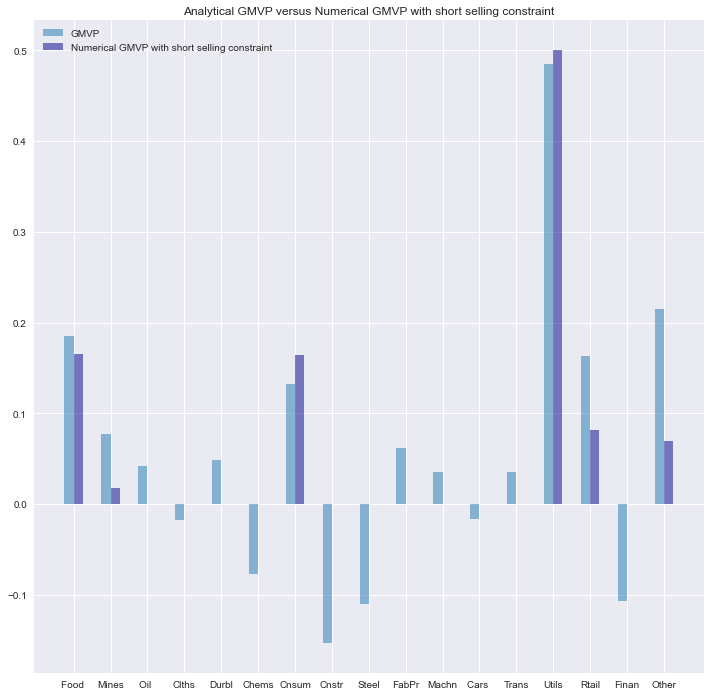

In [19]:
ind = np.arange(N)

plt.figure(figsize=(12, 12))
plt.bar(ind, GMVP, width=0.25, alpha=0.5, color=cmap[0])
plt.bar(ind + 0.25, NGMVPnoSS.x, width=0.25, alpha=0.5, color='darkblue')
plt.xticks(ind + 0.25 / 2, ER.index)

plt.legend(['GMVP','Numerical GMVP with short selling constraint'])
plt.title('Analytical GMVP versus Numerical GMVP with short selling constraint')
plt.show()

In [20]:
from scipy.optimize import Bounds

bounds = Bounds(0, 1)
x0 = MSRP

cons = ({'type': 'eq', 'fun' : lambda x: np.sum(x) - 1})
NMSRPnoSS = minimize(sharpe, x0, method='SLSQP', constraints=cons, args=(ER, S),
options={'disp': True, 'ftol': 1e-9},
bounds=bounds)

NMSRPnoSS

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.22819911837659115
            Iterations: 15
            Function evaluations: 270
            Gradient evaluations: 15


     fun: -0.22819911837659115
     jac: array([-1.50874257e-07,  2.29488760e-02,  1.83588527e-02,  1.69858616e-02,
        7.69604668e-02,  5.41345757e-02,  6.15790486e-06,  2.72941124e-02,
        1.20903715e-01,  3.09783481e-02,  8.09325278e-03,  8.07456858e-03,
        3.30025144e-02, -6.94766641e-07, -6.73905015e-06,  4.14768849e-02,
        1.31459795e-02])
 message: 'Optimization terminated successfully'
    nfev: 270
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([2.52267115e-01, 7.64531938e-18, 1.71490291e-17, 2.65087431e-17,
       0.00000000e+00, 0.00000000e+00, 2.70913135e-01, 0.00000000e+00,
       0.00000000e+00, 1.48391702e-17, 1.25250762e-17, 1.01389844e-17,
       0.00000000e+00, 2.62122020e-01, 2.14697731e-01, 4.49096869e-18,
       1.48484876e-18])

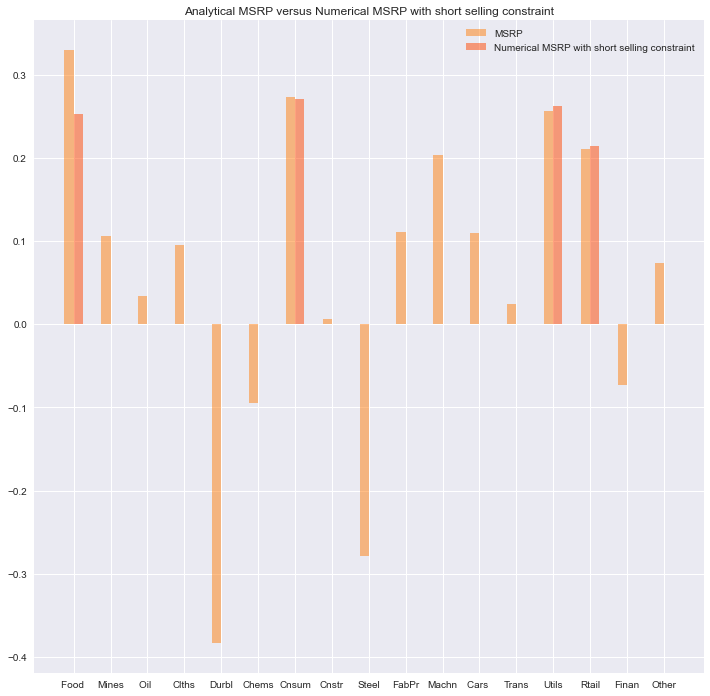

In [21]:
ind = np.arange(N)

plt.figure(figsize=(12, 12))
plt.bar(ind, MSRP, width=0.25, alpha=0.5, color=cmap[1])
plt.bar(ind + 0.25, NMSRPnoSS.x, width=0.25, alpha=0.5, color='orangered')
plt.xticks(ind + 0.25 / 2, ER.index)

plt.legend(['MSRP','Numerical MSRP with short selling constraint'])
plt.title('Analytical MSRP versus Numerical MSRP with short selling constraint')
plt.show()


## Numerical MVF

2021.12.22 different from note!! [待檢查]

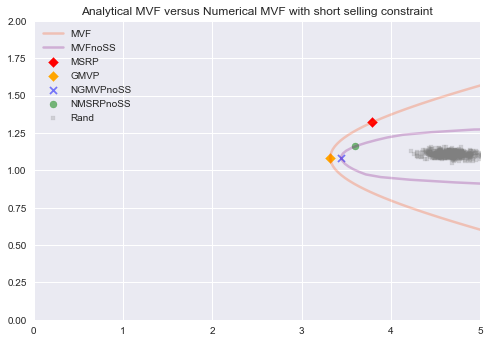

In [22]:
GMVPR = pret(GMVP, R)
GMVPSD = np.sqrt(pvar(GMVP, S))

MSRPR = pret(MSRP, R)
MSRPSD = np.sqrt(pvar(MSRP, S))

NGMVPnoSSR = pret(NGMVPnoSS.x, R)
NGMVPnoSSSD = np.sqrt(pvar(NGMVPnoSS.x, S))

NMSRPnoSSR = pret(NMSRPnoSS.x, R)
NMSRPnoSSSD = np.sqrt(pvar(NMSRPnoSS.x, S))

W = np.linspace(-4, 4, 100, endpoint=True)
MVFR = []
MVFSD = []
for u in W:
    MVFR.append(u*GMVPR + (1-u)*MSRPR)
    MVFSD.append(np.sqrt(u**2 * GMVPSD**2 + (1-u)**2 * MSRPSD**2 + 2*u*(1-u)*np.dot(GMVP, np.dot(S, MSRP))))

NRand = 500
WRand = pd.DataFrame(np.random.uniform(0, 1, size=(NRand, N)))
WRand = WRand.divide(WRand.sum(axis=1), axis=0).to_numpy()

RandR = []
RandSD = []

for i in range(NRand):
    RandR.append(pret(WRand[i], R))
    RandSD.append(np.sqrt(pvar(WRand[i], S)))

MVFnoSSR = []
MVFnoSSSD = []

TR = np.linspace(0, 1.75, 100, endpoint=True)
for r in TR:
    x0 = np.arange(N)/N
    cons = ({'type': 'eq', 'fun' : lambda x: np.sum(x) - 1},
    {'type': 'eq', 'fun' : lambda x: pret(x, R) - r})
    TMP = minimize(pvar, x0, method='SLSQP', constraints=cons, args=S,
    options={'disp': False, 'ftol': 1e-9}, bounds=bounds)
    MVFnoSSR.append(pret(TMP.x, R))
    MVFnoSSSD.append(np.sqrt(pvar(TMP.x, S)))

plt.plot(MVFSD, MVFR, color='orangered', linewidth=2.5, alpha=0.25)
plt.plot(MVFnoSSSD, MVFnoSSR, color='purple', linewidth=2.5, alpha=0.25)
plt.scatter(x=MSRPSD, y=MSRPR, c='red', marker='D', s=50, alpha=1)
plt.scatter(x=GMVPSD, y=GMVPR, c='orange', marker='D', s=50, alpha=1)
plt.scatter(x=NGMVPnoSSSD, y=NGMVPnoSSR, c='blue', marker='x', s=50, alpha=0.5)
plt.scatter(x=NMSRPnoSSSD, y=NMSRPnoSSR, c='green', marker='o', s=50, alpha=0.5)
plt.scatter(x=RandSD, y=RandR, c='gray', marker=',', s=10, alpha=0.25)
plt.xlim([0, 5])
plt.ylim([0, 2])
plt.legend(['MVF','MVFnoSS','MSRP','GMVP','NGMVPnoSS','NMSRPnoSS','Rand'])
plt.title('Analytical MVF versus Numerical MVF with short selling constraint')
plt.show()

---

## Backtesting

In [23]:
# 把上面看過的東西做成 function
def gmvp(S):
    ONE = np.ones(len(S))
    return (inv(S) @ ONE) / (ONE.T @ inv(S) @ ONE)

def msrp(ER, S): 
    ONE = np.ones(len(S))
    return (inv(S) @ ER) / (ONE.T @ inv(S) @ ER)

def pret(w, R): # different from 第一個!!! 這個是 * R，上面是 * ER
    return (w @ R)


use tqdm to get progress bar!

In [24]:
df_ER

,Food,Mines,Oil,Clths,Durbl,Chems,Cnsum,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
Date,,,,,,,,,,,,,,,,,
1980-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-02,3.05,12.93,13.02,1.88,3.92,3.16,-3.10,7.95,16.70,6.46,6.93,9.88,15.29,0.80,-0.55,1.29,3.14
1980-03,-6.18,2.88,11.73,-1.61,-6.18,-2.56,-4.91,-2.97,-0.79,-1.91,-4.71,-7.35,-7.43,-4.25,-6.21,-5.91,-2.22
1980-04,-10.15,-19.95,-18.97,-10.19,-6.77,-13.13,-4.02,-16.00,-19.85,-17.85,-13.97,-10.70,-14.13,-7.88,-9.33,-10.07,-11.05
1980-05,5.88,-1.82,5.58,2.39,0.93,3.55,3.81,2.76,1.05,2.77,-1.16,-4.31,-1.86,10.70,3.37,5.57,5.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06,2.17,10.04,6.14,-0.40,3.50,5.06,2.02,-0.44,14.49,-3.37,1.96,-5.46,2.71,-1.17,-2.64,3.07,-0.88
2021-07,-2.17,-9.27,5.67,8.06,6.15,-5.35,2.17,-1.96,-6.09,2.22,4.43,5.22,-3.58,-1.42,3.72,-2.17,4.70
2021-08,-0.05,1.53,-8.84,4.34,-0.58,-0.78,3.68,1.71,7.14,0.44,1.59,0.63,-3.49,2.94,-0.62,0.28,2.72


In [25]:
WSize = 60 # 每 5 年 (60 個月) roll 一次
AvgER_rolling = df_ER.rolling(WSize).mean() # rolling historical averages
CovER_rolling = df_ER.rolling(WSize).cov() # rolling histroical variance-covariance matrix

Backtest_R = pd.DataFrame(index=df_R.index,columns=['GMVP','MSRP','EW'])

for d in df_ER.index:
    ER = AvgER_rolling.loc[d]
    S = CovER_rolling.loc[d]
    R = df_R.loc[d]
    Backtest_R.loc[d,'GMVP'] = pret(gmvp(S), R) # return using gmvp weights
    Backtest_R.loc[d,'MSRP'] = pret(msrp(ER, S), R) # return using msrp weights

Backtest_R.loc[:,'EW'] = df_R.mean(axis=1) # equal weights 的 return 就是各產業 return 的平均
Backtest_R = Backtest_R.loc[(df_R.index[0] + WSize):] # 因為一開始要 roll 五年，所以會有五年沒有資料，刪除之

In [26]:
Backtest_R.head()

,GMVP,MSRP,EW
Date,,,
1985-01,-0.014976,1.139076,8.832353
1985-02,2.257155,3.885498,1.530588
1985-03,7.091011,9.482728,-0.558824
1985-04,-1.504979,1.817686,-1.219412
1985-05,3.621484,11.144475,6.197647


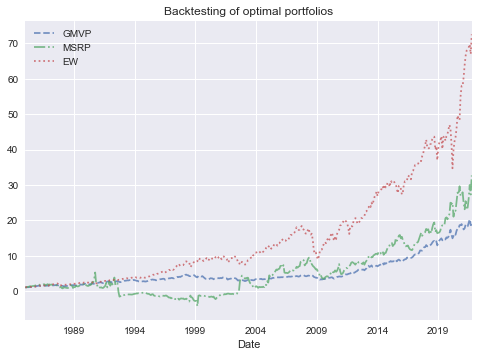

In [27]:
plt.style.use('seaborn')

CumRet = (1 + Backtest_R.divide(100)).cumprod() 
CumRet['GMVP'].plot(alpha=0.75, linestyle="--")
CumRet['MSRP'].plot(alpha=0.75, linestyle="-.")
CumRet['EW'].plot(alpha=0.75, linestyle=":")

plt.legend()
plt.title('Backtesting of optimal portfolios')
plt.show()


注意到上面:  
- MSRP 策略在約 1990 年就 bankrupt 了 => not a good strategy in general
- GMVP 表現相對正常，原因: GMVP 試著極小化變異數，而變異數是歷史資料，因此有一定準確度。  
但 MSRP 是要極大化 Sharpe Ratio，而 Sharpe Ratio 公式裡有 E(R) [expected return]，使預期的，因此準確度較低。